Xpos = [146.30338947] Ypos = [92.90524163] Yaw = [124.52783063]


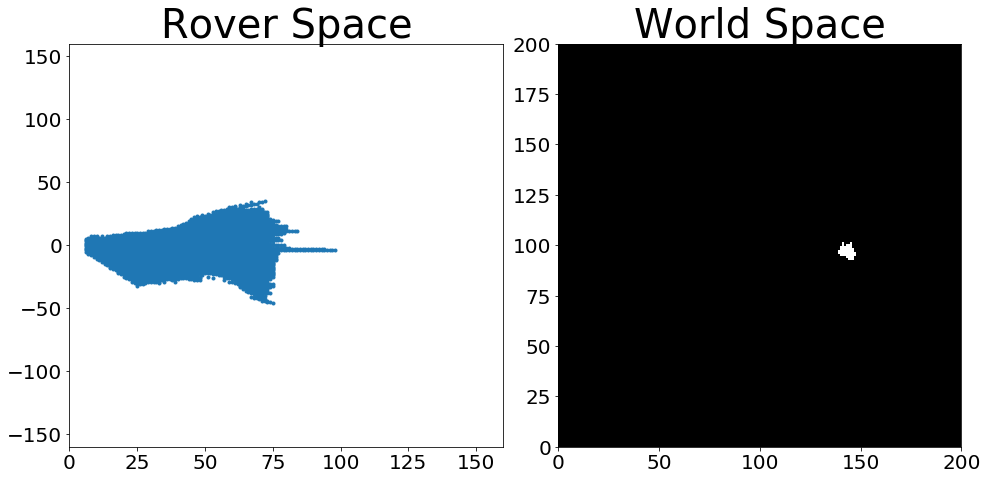

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import numpy as np
import cv2
%matplotlib inline

image = mpimg.imread('sample.jpg')


def perspect_transform(img, src, dst):
    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

def color_thresh(img, rgb_thresh=(170, 170, 170)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    return color_select
    
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

rover_yaw = np.random.random(1)*360
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20


# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    return xpix_translated, ypix_translated


def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    return x_pix_world, y_pix_world


dst_size = 5 
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show() 